# Predict weather
For renewable generation, predict:
- Irradiance (GHI)
- Temperature
- Wind speed

In [1]:
!pip install darts
#!pip install pandas
#!pip install numpy
#!pip install plotly

!pip install pyyaml #==5.4.1 # Google colab

#GPU: https://unit8co.github.io/darts/userguide/gpu_and_tpu_usage.html
#!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

!pip install -U optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 kB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.5 MB/s eta 0:00:0000:0100:01
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181102 sha256=2b110a91c6505f0ec607d568efa6e17267ea1559e40e7d065fe9fa26c0dff03d
  Stored in directory: /root/.cache/pip/wheels/a4/97/94/6574311546af4d192630d77eacb23eb1b2b9e5b1a87ebea4c7
Successfully built pyod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 33.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
E

In [2]:
import darts as dts
import pandas as pd
import numpy as np
import plotly.express as px

In [3]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
#from darts import concatenate

In [4]:
N_DAY = 24 * 4 #number of slots in a day
N_HOURS = 23 # from 0 to 23 hour in day
N_MINS = 45 # from 0 to 45 min in hour

In [5]:
import os
print("File location using os.getcwd():", os.getcwd())

PATH="" # default path for local execution on PC
WORK_DIR = PATH

#!rm /kaggle/working/state.db

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PATH = "/content/drive/My Drive/Colab Notebooks/time_series/" # set path for colab
  WORK_DIR = PATH

  #https://colab.research.google.com/notebooks/io.ipynb#scrollTo=c2W5A2px3doP
  from google.colab import drive
  drive.mount('/content/drive')

if 'kaggle' in str(os.getcwd()):
  PATH = "/kaggle/input/"
  WORK_DIR = "/kaggle/working/darts_logs/"


df2017 = pd.read_csv(PATH + 'nsrdb-tours/361685_47.41_0.78_2017.csv', skiprows=2)
df2018 = pd.read_csv(PATH + 'nsrdb-tours/361685_47.41_0.78_2018.csv', skiprows=2)
df2019 = pd.read_csv(PATH + 'nsrdb-tours/361685_47.41_0.78_2019.csv', skiprows=2)

File location using os.getcwd(): /kaggle/working


In [6]:
#TODO: predict with solar position: https://climlab.readthedocs.io/en/latest/api/climlab.solar.insolation.html

In [7]:
# df = pd.read_csv('dataset1_tropical.csv', sep=";")
#df['datetime'] = pd.to_datetime(df['datetime'])

#concatenate in a whole dataset
df = pd.concat([df2017, df2018, df2019])

#genenarate a datetime index column
df['datetime'] = pd.to_datetime(df['Year'].astype(str) +'-' 
                                + df['Month'].astype(str) 
                                + '-' + df['Day'].astype(str) 
                                + ' ' + df['Hour'].astype(str) 
                                + ':' + df['Minute'].astype(str) + ':00'
                                )

#set datetiem as index
df = df.set_index('datetime')

#drop useless columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

# accelerate processing by reducing information
df = df.astype(np.float32)

In [8]:
#df.info() # check dataframe info
#df.isnull().sum()  # check missing value

In [9]:
# plot one year of data
#fig = px.line(df.loc['2017-1-1':'2017-12-31'])
#fig.show()

In [10]:
# # proccess average on value
# frequency = pd.Timedelta('15 min') # set frequency
# df_resampled = df.resample(frequency).mean() # apply average
# df_resampled.info() # check if dataset is shorter
# #WARNING: cloud type and fill flag are false now (you can't average indexes)

df_daylight = df.between_time('9:00','17:00') # select during daylight

Correlation matrix

In [11]:
#plot correlation of GHI with others variables during daylight
fig = px.imshow(df_daylight.corr())
fig.show()

In [12]:
fig = px.box(x=df_daylight.index.month, y=df_daylight['GHI'])
fig.show()

In [13]:
fig = px.box(x=df.index.month, y=df['Wind Speed'])
fig.show()

## Extract and normalize variables

In [14]:
# extract explainable variables, aka features
series_temperature = dts.timeseries.TimeSeries.from_series(df['Temperature']).astype(np.float32)
#series_ghi = dts.timeseries.TimeSeries.from_series(df_daylight['GHI'] # WARNING: between_time('7:00','17:00') #FIX: missing dates
series_ghi = dts.timeseries.TimeSeries.from_series(df['GHI']).astype(np.float32)
series_pressure = dts.timeseries.TimeSeries.from_series(df['Pressure']).astype(np.float32)
series_water = dts.timeseries.TimeSeries.from_series(df['Precipitable Water']).astype(np.float32)
series_wddir= dts.timeseries.TimeSeries.from_series(df['Wind Direction']).astype(np.float32)
series_wdspeed = dts.timeseries.TimeSeries.from_series(df['Wind Speed']).astype(np.float32)

In [15]:
# normalize to use with machine learning
from darts.dataprocessing.transformers import Scaler
scaler_temp = Scaler()
scaler_ghi = Scaler()
scaler_pressure = Scaler()
scaler_water = Scaler()
scaler_wddir = Scaler()
scaler_wdspeed = Scaler()

# series_scaled
series_s_temp = scaler_temp.fit_transform(series_temperature)
series_s_ghi = scaler_ghi.fit_transform(series_ghi)
series_s_pressure = scaler_pressure.fit_transform(series_pressure)
series_s_water = scaler_water.fit_transform(series_water)
series_s_wddir = scaler_wddir.fit_transform(series_wddir)
series_s_wdspeed = scaler_wdspeed.fit_transform(series_wdspeed)

# to inverse scaled with
# scaler_ghi.inverse_transform(series_s_ghi).plot()

In [16]:
## plot with plotly for interativity
#fig = px.line(series_s_ghi.pd_dataframe())
#fig.show()

## Set covariates
Some variables (past mesured pressure for example) can be past covariate
* past covariates: Data known only in the past. e.g. wind and pressure measurements
* future covariates: Data known in the past and future. e.g. calendar, holidays, the day of the year (sunrise and sunset)...

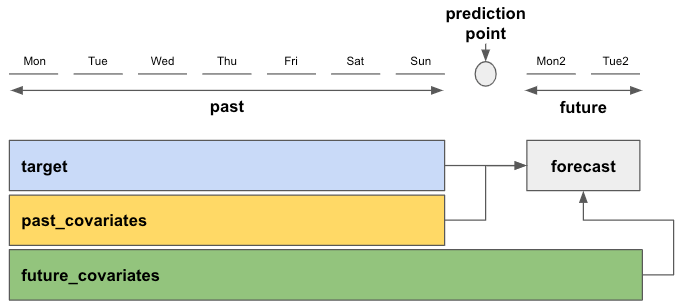

In [17]:
# set covariates

df_hour = pd.DataFrame(data=np.float32((df.index.hour.values + df.index.minute.values/59)/24),
                        #normalize inequality 0 <= (hour + min/59)/24 <= 1
                       index = df.index,
                       columns = ['hour'])
hour = dts.timeseries.TimeSeries.from_series(df_hour) # convert to darts timeseries

#https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
#https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/
#TODO: encode with sin cos

# futures covariates
future_covariates = dts.concatenate(
    [
        hour, #normalized
        # from API pandas documentation: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
        #dt_attr(df.index, "dayofyear", dtype=np.float32)/366,  # normalized, for seasons and thermal sensibility
        dt_attr(df.index, "weekofyear", dtype=np.float32)/52,  # normalized, for seasons and thermal sensibility
    ],
    axis="component",
)

future_covs_consumption = dts.concatenate(
    [
        future_covariates,
        dt_attr(df.index, "dayofweek", dtype=np.float32)/6
    ],
    axis="component",
)
future_covs_consumption = future_covariates.add_holidays("FR")  # for human consumption

# past covariation
past_covariates = dts.concatenate(
    [
        series_s_pressure, # could be a good candidate to explain cloudy days
        #series_s_wdspeed,
    ],
    axis="component",
)

In [18]:
#plot covariates
#px.line(future_covariates.pd_dataframe())

In [19]:
## concatenate a multivariate
## To predict two or more variables in same time
#multivar_ghi = dts.concatenate([series_s_ghi, series_s_temp], axis=1)

## Time series analysis

In [20]:
## acf
#from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf
#plot_acf(series_s_ghi, m=N_DAY, alpha=0.05, max_lag=N_DAY*3)
#plot_pacf(series_s_ghi, m=N_DAY, alpha=0.05, max_lag=N_DAY*3)
#check_seasonality(series_ghi, m=N_DAY, alpha=0.05, max_lag=N_DAY*3)

## Model splitting
=> Keep a generalizable model

Separate into training, validation and test datasets. Training is used for learning, validation to verify that the model can be generalized to other data and testing to verify that the model works correctly on data not yet seen.
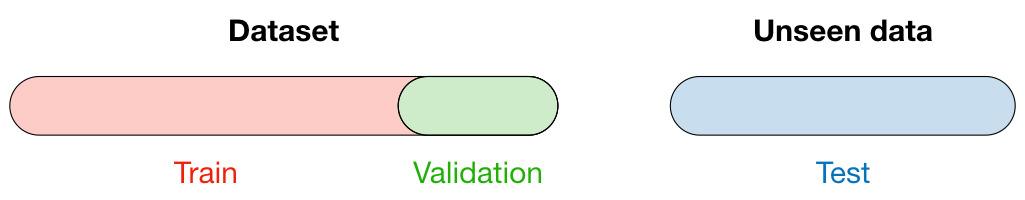

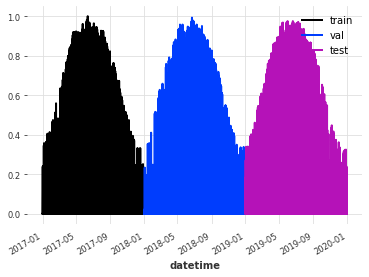

In [21]:
## use train test dateset
#train, test = series_s_ghi.split_before(2./3.) #basic split into two dataset

#use train test validation dataset to avoid overfitting

LEN_S = len(series_s_ghi)//3 #lenght of split

train = series_s_ghi[:LEN_S]
val = series_s_ghi[LEN_S:LEN_S*2]
test = series_s_ghi[LEN_S*2:LEN_S*3]

train.plot(label="train")
val.plot(label="val")
test.plot(label="test")

# Machine learning
Generic configuration for machine learning models with:
- Early stop to avoid over fitting
- GPU activation
- The use of optuna to find the hyper parameters

### Early stop callback
https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#early-stop

you have to set enough epochs so that the model minimizes the bias, but not too much so that the model correctly predicts datasets not yet seen. In practice, set good parameters on EarlyStopping()

See https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks#diagnostics

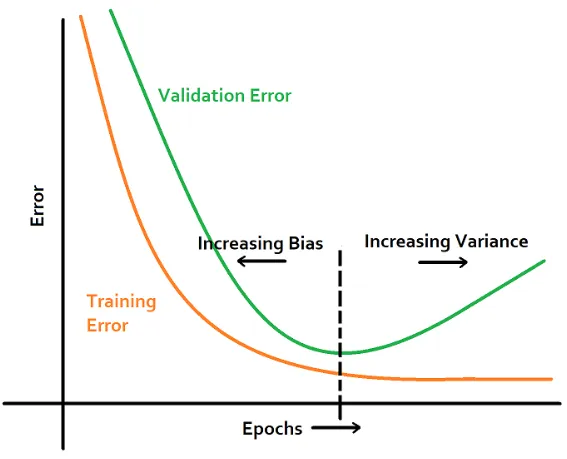

In [44]:
import torch
import optuna
from optuna.integration import PyTorchLightningPruningCallback # BUG in lib 
from pytorch_lightning.callbacks import EarlyStopping
# Early stop callback
#https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#early-stop
#https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

from darts.utils.likelihood_models import GaussianLikelihood

#how to choose metric? https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
from darts.metrics import smape #Symmetric Mean Absolute Percentage Error
from darts.metrics import rmse #root mean square error
metric = smape

# throughout training we'll monitor the validation loss for both pruning and early stopping
#pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)

# detect if a GPU is available
#GPU: https://unit8co.github.io/darts/userguide/gpu_and_tpu_usage.html
if torch.cuda.is_available():
    print("GPU")
    pl_trainer_kwargs = {
          "accelerator": "gpu",# "devices": -1, "auto_select_gpus": True,
          "devices": [0],
          "callbacks": [early_stopper,],
    }
    num_workers = 2
else:
    print("CPU")
    pl_trainer_kwargs = {
        "callbacks": [early_stopper,]
        }
    num_workers = 4
    #map_location=torch.device('cpu')

CPU


## TCN
### Hyper parameters optimization

Inspired from: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html

https://unit8co.github.io/darts/examples/15-static-covariates.html

**TODO**:
* understand what the parameters are related to
* use better metric than MAPE (RMSE?)
* optimize hyper parameters
* understand how to set encoders
* save(): check is it saving the whole model or only parameters

In [37]:
#hyper parameters optimization with early stop
from darts.models import TCNModel

#TODO for latter, cross validation : https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html
# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 3, 15)

    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 1, 5)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    include_time = trial.suggest_categorical("year", [False, True])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    callbacks = [pruner, early_stopper]
    
    # optionally also add the (scaled) year value as a past covariate
    if include_time:
        encoders = {
            #"datetime_attribute": {"future": ['hour', 'weekofyear']},
            'cyclic': {"past": ['hour', 'weekofyear']},
            "transformer": Scaler()}
    else:
        encoders = None

    # reproducibility
    #torch.manual_seed(42)

    # build the TCN model
    model = TCNModel(
        input_chunk_length = N_DAY * in_len,
        output_chunk_length = N_DAY * 2,
        batch_size=32,
        n_epochs=100,
        nr_epochs_val_period=1,
        kernel_size=kernel_size,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=GaussianLikelihood(),
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tcn_model",
        force_reset=True,
        save_checkpoints=True,
        work_dir=WORK_DIR,
        show_warnings=True,
        log_tensorboard=True, #https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    #model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])

    # train the model
    model.fit(
        series=train,
        val_series=val,
        num_loader_workers=num_workers,
        #future_covariates=future_covariates,
        #past_covariates=future_covariates,
    )

    # reload best model over course of training
    model = TCNModel.load_from_checkpoint(WORK_DIR + "tcn_model")

    # Evaluate how good it is on the validation set, using metric
    preds = model.predict(
        series=train,
        n=LEN_S,
        #future_covariates=future_covariates,
        #past_covariates=future_covariates,
        )
    metrics = metric(val, preds, n_jobs=-1, verbose=True)
    metric_val = np.mean(metrics)

    return metric_val if metric_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the metric on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, callbacks=[print_callback])

#to text file
with open(WORK_DIR + "tcn_parameters.txt", "w") as text_file:
  text_file.write(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

optuna.visualization.plot_optimization_history(study)
study.best_trial.save(WORK_DIR + "tcn.pkl") # TODO: check

[I 2023-02-09 16:33:40,092] A new study created in memory with name: no-name-9c74bb1e-0805-4017-b237-13a620075655
[W 2023-02-09 16:33:40,253] Trial 0 failed with parameters: {'in_len': 8, 'kernel_size': 5, 'num_filters': 4, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.3391002688970173, 'lr': 0.000698991379000809, 'year': True} because of the following error: AttributeError("Can't pickle local object 'EvaluationLoop.advance.<locals>.batch_to_device'").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_27/208932406.py", line 67, in objective
    num_loader_workers=num_workers,
  File "/opt/conda/lib/python3.7/site-packages/darts/utils/torch.py", line 112, in decorator
    return decorated(self, *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/darts/models/forecasting/torch_forecasting_model.py", line 761, in fit
    train_dat

AttributeError: Can't pickle local object 'EvaluationLoop.advance.<locals>.batch_to_device'

### Implement and use parameters found from hyper optimization
see tcn_sMAPE_parameters


{'in_len': 8, 'kernel_size': 2, 'num_filters': 2, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.21793113011971788, 'lr': 5.869708790776834e-05, 'year': True}

Best value: 152.03417539596558, Best params: {'in_len': 7, 'kernel_size': 2, 'num_filters': 3, 'weight_norm': True, 'dilation_base': 3, 'dropout': 0.2731263829502545, 'lr': 0.00026101532587145083, 'year': True}

Best value: 146.50543928146362, Best params: {'in_len': 10, 'kernel_size': 3, 'num_filters': 4, 'weight_norm': False, 'dilation_base': 3, 'dropout': 0.09354574033384853, 'lr': 0.00045913023827951377, 'year': True}

In [39]:
pl_trainer_kwargs

{'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping at 0x7fbdba9c1a90>]}

In [ ]:
from darts.models import TCNModel

tcn_model = TCNModel(
    input_chunk_length = N_DAY * 10,
    output_chunk_length = N_DAY * 2,
    kernel_size=3,
    weight_norm=False,
    dilation_base=3,
    batch_size=32,
    n_epochs=100,
    nr_epochs_val_period=1,
    num_filters=4,
    dropout=0.09354574033384853,
    optimizer_kwargs={"lr": 0.00045913023827951377},
    add_encoders={
        'cyclic': {"future": ['hour', 'weekofyear']},
        "transformer": Scaler()},
    likelihood=GaussianLikelihood(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="tcn_model",
    force_reset=True,
    save_checkpoints=True,
    show_warnings=True,
    log_tensorboard=True, #https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
    work_dir=WORK_DIR
)

# train the model
tcn_model.fit(
    series=train,
    val_series=val,
    num_loader_workers=num_workers,
    #future_covariates=future_covariates,
    #past_covariates=future_covariates,
)

tcn_model.save(WORK_DIR + "tcn.pkl")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### plot prediction with TCN
**TODO**:
- filter values below 0 and above 0 at night
- try with "num_samples > 1" and filter value below 0 in the dataframe

In [ ]:
from darts.models import TCNModel
#tcn_model = TCNModel.load(WORK_DIR + "tcn.pkl") #load best model #tcn_sMAPE.pkl
# make a prediction with the same covariate types
pred = tcn_model.predict(n=LEN_S,
                         num_samples=1,
                         series=val,  # this is only required for GFMs
                         #past_covariates=past_covariates,
                         #future_covariates=future_covariates
                         )

GHI_pred = pred.pd_dataframe()
GHI_pred = GHI_pred.rename(columns={'GHI': 'GHI_Predicted'})
GHI_pred["GHI"] = test["GHI"][GHI_pred.index].pd_dataframe()

fig = px.line(GHI_pred)
fig.show()
pred.plot()

In [ ]:
## make a prediction with the same covariate types
#pred = tft_model.predict(n=N_DAY*7,
#                         num_samples=1,
#                         series=test[N_DAY*30*7:N_DAY*30*8],  # this is only required for GFMs
#                         #past_covariates=past_covariates,
#                         future_covariates=future_covariates)
#
###plot with de normalisation
##fig = px.line(scaler_ghi.inverse_transform(pred).pd_dataframe())
##fig.show()

**TODO**
* try with covariates (pressure...) to check is there is improvements -> implement in hyper parameters optimization loop
* compare with TFT: https://unit8co.github.io/darts/examples/13-TFT-examples.html